# Machine Learning - Route Optimization example

###### Links: [Starbucks dataset (Kaggle)](https://www.kaggle.com/starbucks/store-locations)  |  [Article (TowardsDataScience)]()

### 0 - Setup

###### Import pckgs

In [1]:
import warnings
warnings.filterwarnings("ignore")

## for data
import pandas as pd  #1.1.5
import numpy as np  #1.21.0
from tqdm import tqdm

## for plotting
import matplotlib.pyplot as plt  #3.3.2
import folium  #0.14.0
from folium import plugins
import plotly.express as px  #5.1.0

## for simple routing
import osmnx as ox  #1.2.2
import networkx as nx  #3.0

## for advanced routing 
from ortools.constraint_solver import pywrapcp  #9.6
from ortools.constraint_solver import routing_enums_pb2

###### Import data

In [2]:
city = "Hong Kong"

dtf = pd.read_csv('data_stores.csv')
dtf = dtf[dtf["City"]==city][["City","Street Address","Latitude","Longitude"]].reset_index(drop=True)
dtf = dtf.reset_index().rename(columns={"index":"id", "Latitude":"y", "Longitude":"x"})

print("tot:", len(dtf))
dtf.head(3)

tot: 104


id       City                                     Street Address      y   
0   0  Hong Kong  Shop No.101, 1st Floor, Liberte Place, 8, 33 L...  22.33  \
1   1  Hong Kong  Shop B, Ground Floor, 50 Connaught Central, Ce...  22.29   
2   2  Hong Kong         Office Lobby, G/F Exchange Square, Central  22.28   

        x  
0  114.15  
1  114.16  
2  114.16

In [3]:
# Pinpoint your location
i = 0
dtf["base"] = dtf["id"].apply(lambda x: 1 if x==i else 0)
start = dtf[dtf["base"]==1][["y","x"]].values[0]

print("start =", start)
dtf.head(3)

start = [ 22.33 114.15]


id       City                                     Street Address      y   
0   0  Hong Kong  Shop No.101, 1st Floor, Liberte Place, 8, 33 L...  22.33  \
1   1  Hong Kong  Shop B, Ground Floor, 50 Connaught Central, Ce...  22.29   
2   2  Hong Kong         Office Lobby, G/F Exchange Square, Central  22.28   

        x  base  
0  114.15     1  
1  114.16     0  
2  114.16     0

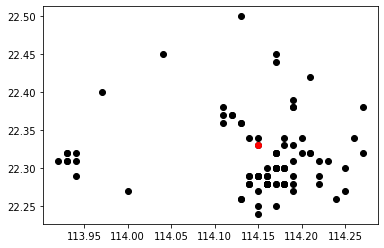

In [4]:
plt.scatter(y=dtf["y"], x=dtf["x"], color="black")
plt.scatter(y=start[0], x=start[1], color="red")
plt.show()

In [5]:
'''
Creates a map with folium.
:parameter
    :param dtf: pandas
    :param (y,x): str - columns with (latitude, longitude)
    :param starting_point: list - (latitude, longitude)
    :param tiles: str - "cartodbpositron", "OpenStreetMap", "Stamen Terrain", "Stamen Toner"
    :param popup: str - column with text to popup if clicked, if None there is no popup
    :param size: str - column with size variable, if None takes size=5
    :param color: str - column with color variable, if None takes default color
    :param lst_colors: list - list with multiple colors to use if color column is not None, if not given it generates randomly
    :param marker: str - column with marker variable, takes up to 7 unique values
:return
    map object to display
'''
def plot_map(dtf, y, x, start, zoom=12, tiles="cartodbpositron", popup=None, size=None, color=None, legend=False, lst_colors=None, marker=None):
    data = dtf.copy()

    ## create columns for plotting
    if color is not None:
        lst_elements = sorted(list(dtf[color].unique()))
        lst_colors = ['#%06X' % np.random.randint(0, 0xFFFFFF) for i in range(len(lst_elements))] if lst_colors is None else lst_colors
        data["color"] = data[color].apply(lambda x: lst_colors[lst_elements.index(x)])

    if size is not None:
        scaler = preprocessing.MinMaxScaler(feature_range=(3,15))
        data["size"] = scaler.fit_transform(data[size].values.reshape(-1,1)).reshape(-1)

    ## map
    map_ = folium.Map(location=start, tiles=tiles, zoom_start=zoom)

    if (size is not None) and (color is None): 
        data.apply(lambda row: folium.CircleMarker(location=[row[y],row[x]], popup=row[popup],
                                                   color='#3186cc', fill=True, radius=row["size"]).add_to(map_), axis=1)
    elif (size is None) and (color is not None):
        data.apply(lambda row: folium.CircleMarker(location=[row[y],row[x]], popup=row[popup],
                                                   color=row["color"], fill=True, radius=5).add_to(map_), axis=1)
    elif (size is not None) and (color is not None):
        data.apply(lambda row: folium.CircleMarker(location=[row[y],row[x]], popup=row[popup],
                                                   color=row["color"], fill=True, radius=row["size"]).add_to(map_), axis=1)
    else:
        data.apply(lambda row: folium.CircleMarker(location=[row[y],row[x]], popup=row[popup],
                                                   color='#3186cc', fill=True, radius=5).add_to(map_), axis=1)
    
    ## tiles
    layers = ["cartodbpositron", "openstreetmap", "Stamen Terrain", 
              "Stamen Water Color", "Stamen Toner", "cartodbdark_matter"]
    for tile in layers:
        folium.TileLayer(tile).add_to(map_)
    folium.LayerControl(position='bottomright').add_to(map_)
    
    ## legend
    if (color is not None) and (legend is True):
        legend_html = """<div style="position:fixed; bottom:10px; left:10px; border:2px solid black; z-index:9999; font-size:14px;">&nbsp;<b>"""+color+""":</b><br>"""
        for i in lst_elements:
            legend_html = legend_html+"""&nbsp;<i class="fa fa-circle fa-1x" style="color:"""+lst_colors[lst_elements.index(i)]+""""></i>&nbsp;"""+str(i)+"""<br>"""
        legend_html = legend_html+"""</div>"""
        map_.get_root().html.add_child(folium.Element(legend_html))
    
    ## add marker
    if marker is not None:
        lst_elements = sorted(list(dtf[marker].unique()))
        lst_colors = ["black","red","blue","green","pink","orange","gray"]  #7
        ### too many values, can't mark
        if len(lst_elements) > len(lst_colors):
            raise Exception("marker has uniques > "+str(len(lst_colors)))
        ### binary case (1/0): mark only 1s
        elif len(lst_elements) == 2:
            data[data[marker]==lst_elements[1]].apply(lambda row: folium.Marker(location=[row[y],row[x]], popup=row[marker], draggable=False, 
                                                                                icon=folium.Icon(color=lst_colors[0])).add_to(map_), axis=1) 
        ### normal case: mark all values
        else:
            for i in lst_elements:
                data[data[marker]==i].apply(lambda row: folium.Marker(location=[row[y],row[x]], popup=row[marker], draggable=False, 
                                                                      icon=folium.Icon(color=lst_colors[lst_elements.index(i)])).add_to(map_), axis=1)
    
    ## full screen
    plugins.Fullscreen(position="topright", title="Expand", title_cancel="Exit", force_separate_button=True).add_to(map_)
    return map_

In [6]:
map_ = plot_map(dtf, y="y", x="x", start=start, zoom=11, 
                tiles="cartodbpositron", popup="id", 
                color="base", lst_colors=["black", "red"])
map_

In [7]:
for i in range(len(dtf)):
    points = [start, dtf[["y","x"]].iloc[i].tolist()]
    folium.PolyLine(points, color="red", weight=0.5, opacity=0.5).add_to(map_)
map_

### 1 - Shortest Path (between 2 locations)

###### Create Graph

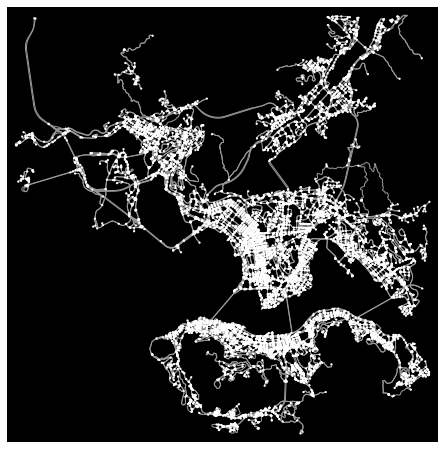

In [8]:
# Create network graph
G = ox.graph_from_point(start, dist=10000, network_type="drive")  #'drive', 'bike', 'walk'
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

fig, ax = ox.plot_graph(G, bgcolor="black", node_size=5, node_color="white", figsize=(16,8))

In [9]:
[i for i in G.nodes()][:10]

[24533064,
 26411640,
 26411641,
 26412251,
 30747332,
 30747334,
 32899260,
 33004487,
 33004488,
 33004530]

In [10]:
# geo-dataframe (nodes)
print("nodes:", len(G.nodes()))
ox.graph_to_gdfs(G, nodes=True, edges=False).reset_index().head(3)

nodes: 9568


osmid          y           x  street_count  ref highway   
0  24533064  22.276527  114.173172             3  NaN     NaN  \
1  26411640  22.250336  114.169964             3  NaN     NaN   
2  26411641  22.250545  114.171056             3  NaN     NaN   

                     geometry  
0  POINT (114.17317 22.27653)  
1  POINT (114.16996 22.25034)  
2  POINT (114.17106 22.25054)

In [11]:
# geo-dataframe (links)
print("links:", len(G.edges()))
ox.graph_to_gdfs(G, nodes=False, edges=True).reset_index().head(3)

links: 17498


u           v  key      osmid  oneway lanes                   name   
0  24533064  1618530627    0  743072632    True     2     莊士敦道 Johnston Road  \
1  24533064   297187423    0  567856161   False     2     莊士敦道 Johnston Road   
2  26411640  3698862626    0   26560287    True     1  海洋公園道 Ocean Park Road   

          highway reversed   length  ...   
0        tertiary    False   38.526  ...  \
1        tertiary    False   30.191  ...   
2  secondary_link    False  130.623  ...   

                                            geometry  ref maxspeed junction   
0  LINESTRING (114.17317 22.27653, 114.17280 22.2...  NaN      NaN      NaN  \
1  LINESTRING (114.17317 22.27653, 114.17332 22.2...  NaN      NaN      NaN   
2  LINESTRING (114.16996 22.25034, 114.17012 22.2...  NaN      NaN      NaN   

  bridge area access tunnel width service  
0    NaN  NaN    NaN    NaN   NaN     NaN  
1    NaN  NaN    NaN    NaN   NaN     NaN  
2    NaN  NaN    NaN    NaN   NaN     NaN  

[3 rows x 22 columns]

###### Dijkstra Algorithm

In [12]:
end = dtf[dtf["id"]==68][["y","x"]].values[0]
print("from", start, "--> to", end)

from [ 22.33 114.15] --> to [ 22.34 114.15]


In [13]:
# find the nearest node to the start/end location
start_node = ox.distance.nearest_nodes(G, start[1], start[0])
end_node = ox.distance.nearest_nodes(G, end[1], end[0])
print("from", start_node, "--> to", end_node)

from 493883072 --> to 480679404


18 nodes --> [493883072, 289293755, 289294146, 289294087, 275816026, 289329905, 1182677821, 1645492788, 1645492916, 1191992694, 5101419365, 332257610, 999331442, 1191992696, 480679312, 999331647, 1641766800, 480679404]


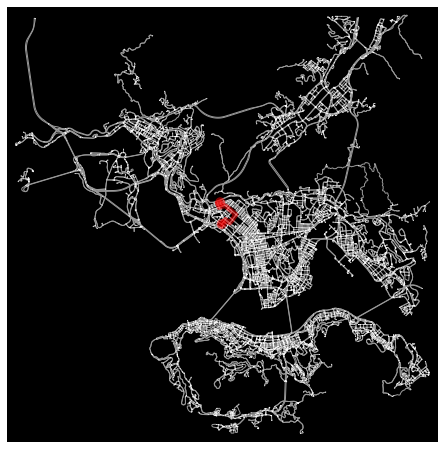

In [14]:
# calculate shortest path
path_lenght = nx.shortest_path(G, source=start_node, target=end_node, method='dijkstra', weight='lenght')
print(len(path_lenght), "nodes -->", path_lenght)

# plot on the graph
fig, ax = ox.plot_graph_route(G, path_lenght, route_color="red", route_linewidth=5,
                              node_size=1, bgcolor='black', node_color="white",
                              figsize=(16,8))

21 nodes --> [493883072, 289293755, 289294146, 289295423, 289295628, 289295766, 289295767, 289295566, 5101376323, 4844635141, 289295620, 274244744, 1641766635, 1641766639, 1641766654, 999331442, 1191992696, 480679312, 999331647, 1641766800, 480679404]


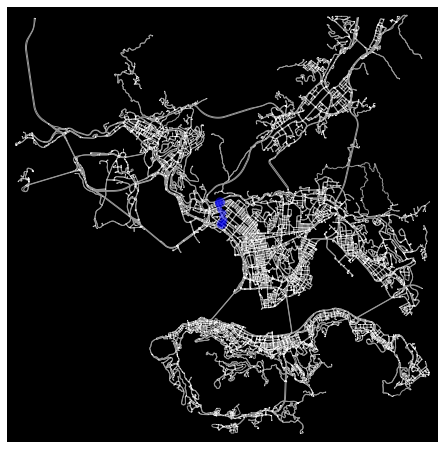

In [15]:
# calculate shortest path
path_time = nx.shortest_path(G, source=start_node, target=end_node, method='dijkstra', weight='travel_time')
print(len(path_time), "nodes -->", path_time)

# plot on the graph
fig, ax = ox.plot_graph_route(G, path_time, route_color="blue", route_linewidth=5, 
                              node_size=1, bgcolor='black', node_color="white", 
                              figsize=(16,8))

Red  route: 2.41 km | 2.78 min
Blue route: 1.49 km | 1.81 min


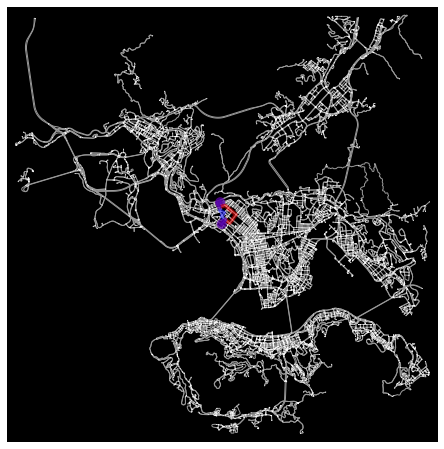

In [16]:
# compare the two routes
print('Red  route:', 
      round(sum(ox.utils_graph.get_route_edge_attributes(G,path_lenght,'length'))/1000, 2), 
      'km |', 
      round(sum(ox.utils_graph.get_route_edge_attributes(G,path_lenght,'travel_time'))/60, 2), 
      'min')

print('Blue route:', 
      round(sum(ox.utils_graph.get_route_edge_attributes(G,path_time,'length'))/1000, 2), 
      'km |', 
      round(sum(ox.utils_graph.get_route_edge_attributes(G,path_time,'travel_time'))/60, 2), 
      'min')

# plot on the graph
fig, ax = ox.plot_graph_routes(G, routes=[path_lenght, path_time], 
                              route_colors=["red","blue"], route_linewidth=5, 
                              node_size=1, bgcolor='black', node_color="white", 
                              figsize=(16,8))

In [17]:
# plot on the map
map_ = plot_map(dtf, y="y", x="x", start=start, zoom=12, 
                tiles="cartodbpositron", popup="id", 
                color="base", lst_colors=["black","red"])

ox.plot_route_folium(G, route=path_lenght, route_map=map_, color="red", weight=1)
ox.plot_route_folium(G, route=path_time, route_map=map_, color="blue", weight=1)
map_

###### Animation

In [18]:
print("from", start_node, "--> to", end_node)

from 493883072 --> to 480679404


In [19]:
lst_start, lst_end = [],[]
start_x, start_y = [],[]
end_x, end_y = [],[]
lst_length, lst_time = [],[]

for a,b in zip(path_time[:-1], path_time[1:]):
    lst_start.append(a)
    lst_end.append(b)
    lst_length.append(round(G.edges[(a,b,0)]['length']))
    lst_time.append(round(G.edges[(a,b,0)]['travel_time']))
    start_x.append(G.nodes[a]['x'])
    start_y.append(G.nodes[a]['y'])
    end_x.append(G.nodes[b]['x'])
    end_y.append(G.nodes[b]['y'])

df = pd.DataFrame(list(zip(lst_start, lst_end, start_x, start_y, end_x, end_y, lst_length, lst_time)), 
                   columns=["start","end","start_x","start_y","end_x","end_y","length","travel_time"]
                  ).reset_index().rename(columns={"index":"id"})

df_start = df[df["start"] == start_node]
df_end = df[df["end"] == end_node]
df.head()

id      start        end     start_x    start_y       end_x      end_y   
0   0  493883072  289293755  114.150598  22.330550  114.151500  22.331566  \
1   1  289293755  289294146  114.151500  22.331566  114.152190  22.332349   
2   2  289294146  289295423  114.152190  22.332349  114.151381  22.332983   
3   3  289295423  289295628  114.151381  22.332983  114.150783  22.333581   
4   4  289295628  289295766  114.150783  22.333581  114.150609  22.333969   

   length  travel_time  
0     146           12  
1     112           10  
2     109            8  
3      91            6  
4      47            3

In [20]:
## setup
#key = "pk.eyJ1Ijoic2hha2Fzb20iLCJhIjoiY2plMWg1NGFpMXZ5NjJxbjhlM2ttN3AwbiJ9.RtGYHmreKiyBfHuElgYq_w"
#px.set_mapbox_access_token(key)

## create basic map
fig = px.scatter_mapbox(data_frame=df, lon="start_x", lat="start_y", zoom=15, width=1000, height=800, 
                        animation_frame="id", mapbox_style="carto-positron")
## add driver
fig.data[0].marker = {"size":12}
## add start point
fig.add_trace(px.scatter_mapbox(data_frame=df_start, lon="start_x", lat="start_y").data[0])
fig.data[1].marker = {"size":15, "color":"red"}
## add end point
fig.add_trace(px.scatter_mapbox(data_frame=df_end, lon="start_x", lat="start_y").data[0])
fig.data[2].marker = {"size":15, "color":"green"}
## add route
fig.add_trace(px.line_mapbox(data_frame=df, lon="start_x", lat="start_y").data[0])
fig

### 2 - Shortest Path with Reinforcement Learning

###### SubGraph 

In [21]:
print("from", start_node, "--> to", end_node)

from 493883072 --> to 480679404


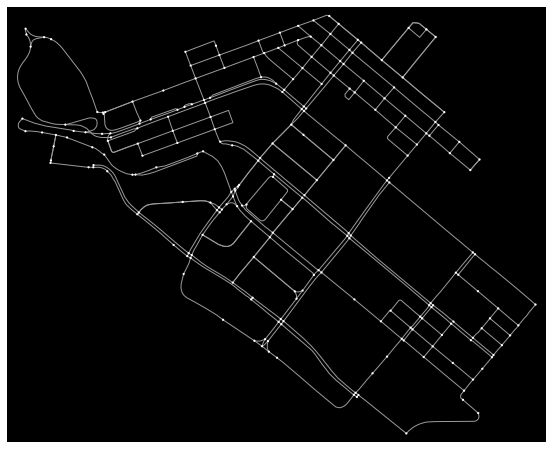

In [22]:
paths_generator = nx.all_simple_paths(G, source=start_node, target=end_node, cutoff=30)  #max number of nodes
subG = G.subgraph({node for path in paths_generator for node in path})

fig, ax = ox.plot_graph(subG, bgcolor="black", node_size=5, node_color="white", figsize=(16,8))

In [23]:
# distance between all the nodes
distance_matrix = pd.DataFrame(nx.floyd_warshall_numpy(subG, weight="travel_time"), 
                               columns=subG.nodes(), index=subG.nodes())
distance_matrix

289295876   4844635141  1645493254  999331337   1194385422   
289295876          0.0        57.0       148.0       102.2        75.7  \
4844635141        60.6         0.0       111.8        53.9        22.1   
1645493254       199.2       138.6         0.0       192.5       160.7   
999331337        201.5       140.9        94.4         0.0       163.0   
1194385422        76.8        16.2       109.2        70.1         0.0   
...                ...         ...         ...         ...         ...   
999331306        117.8        57.2       118.9       111.1        79.3   
480679404        134.0        73.4       135.1       127.3        95.5   
1191992814        91.4        30.8       108.6        84.7        52.9   
1641766386       189.7       129.1       206.9       183.0       147.5   
991294970        136.3        75.7       168.7       129.6        91.5   

            1161205777  6389573139  289295904   1194385446  1645492775  ...   
289295876         73.9       146.3        56.4        62.6       179.3  ...  \
4844635141        74.2       110.1        73.5         9.0       122.3  ...   
1645493254       212.8       198.6       212.1       147.6       240.1  ...   
999331337         20.3        92.7        20.8       149.9       242.4  ...   
1194385422        90.4       107.5        89.7        25.2       119.7  ...   
...                ...         ...         ...         ...         ...  ...   
999331306        131.4       117.2       130.7        66.2       158.7  ...   
480679404        147.6       133.4       146.9        82.4       174.9  ...   
1191992814       105.0       106.9       104.3        39.8       132.3  ...   
1641766386       203.3       205.2       202.6       134.4        68.5  ...   
991294970        149.9       167.0       149.2        78.4        55.1  ...   

            1645493211  1645493214  1641766884  999331300   1161206758   
289295876        150.1       148.1       125.7       121.8        79.3  \
4844635141       113.9       111.9        68.7        64.8        79.6   
1645493254         8.0         6.0       119.3       153.3       218.2   
999331337         96.5        94.5       140.9       155.6        25.7   
1194385422       111.3       109.3        66.1        62.2        95.8   
...                ...         ...         ...         ...         ...   
999331306        121.0       119.0        14.2        71.9       136.8   
480679404        137.2       135.2        54.1        88.1       153.0   
1191992814       110.7       108.7        40.6        61.6       110.4   
1641766386       209.0       207.0       138.9       159.9       208.7   
991294970        170.8       168.8       124.2       121.7       155.3   

            999331306   480679404   1191992814  1641766386  991294970   
289295876        123.6       121.2        88.8       155.7       134.8  
4844635141        66.6        64.2        31.8        98.7        81.2  
1645493254       105.1        84.7       107.8       216.5       205.7  
999331337        126.7       106.3       110.1       218.8       208.0  
1194385422        64.0        61.6        29.2        96.1        85.3  
...                ...         ...         ...         ...         ...  
999331306          0.0        71.3        26.4       135.1       124.3  
480679404         39.9         0.0        42.6       151.3       140.5  
1191992814        38.5        61.0         0.0       108.7        97.9  
1641766386       136.8       159.3       102.0         0.0       132.8  
991294970        122.1       121.1        87.3        31.5         0.0  

[237 rows x 237 columns]

In [24]:
# Rewards
R = -1*distance_matrix
R

289295876   4844635141  1645493254  999331337   1194385422   
289295876         -0.0       -57.0      -148.0      -102.2       -75.7  \
4844635141       -60.6        -0.0      -111.8       -53.9       -22.1   
1645493254      -199.2      -138.6        -0.0      -192.5      -160.7   
999331337       -201.5      -140.9       -94.4        -0.0      -163.0   
1194385422       -76.8       -16.2      -109.2       -70.1        -0.0   
...                ...         ...         ...         ...         ...   
999331306       -117.8       -57.2      -118.9      -111.1       -79.3   
480679404       -134.0       -73.4      -135.1      -127.3       -95.5   
1191992814       -91.4       -30.8      -108.6       -84.7       -52.9   
1641766386      -189.7      -129.1      -206.9      -183.0      -147.5   
991294970       -136.3       -75.7      -168.7      -129.6       -91.5   

            1161205777  6389573139  289295904   1194385446  1645492775  ...   
289295876        -73.9      -146.3       -56.4       -62.6      -179.3  ...  \
4844635141       -74.2      -110.1       -73.5        -9.0      -122.3  ...   
1645493254      -212.8      -198.6      -212.1      -147.6      -240.1  ...   
999331337        -20.3       -92.7       -20.8      -149.9      -242.4  ...   
1194385422       -90.4      -107.5       -89.7       -25.2      -119.7  ...   
...                ...         ...         ...         ...         ...  ...   
999331306       -131.4      -117.2      -130.7       -66.2      -158.7  ...   
480679404       -147.6      -133.4      -146.9       -82.4      -174.9  ...   
1191992814      -105.0      -106.9      -104.3       -39.8      -132.3  ...   
1641766386      -203.3      -205.2      -202.6      -134.4       -68.5  ...   
991294970       -149.9      -167.0      -149.2       -78.4       -55.1  ...   

            1645493211  1645493214  1641766884  999331300   1161206758   
289295876       -150.1      -148.1      -125.7      -121.8       -79.3  \
4844635141      -113.9      -111.9       -68.7       -64.8       -79.6   
1645493254        -8.0        -6.0      -119.3      -153.3      -218.2   
999331337        -96.5       -94.5      -140.9      -155.6       -25.7   
1194385422      -111.3      -109.3       -66.1       -62.2       -95.8   
...                ...         ...         ...         ...         ...   
999331306       -121.0      -119.0       -14.2       -71.9      -136.8   
480679404       -137.2      -135.2       -54.1       -88.1      -153.0   
1191992814      -110.7      -108.7       -40.6       -61.6      -110.4   
1641766386      -209.0      -207.0      -138.9      -159.9      -208.7   
991294970       -170.8      -168.8      -124.2      -121.7      -155.3   

            999331306   480679404   1191992814  1641766386  991294970   
289295876       -123.6      -121.2       -88.8      -155.7      -134.8  
4844635141       -66.6       -64.2       -31.8       -98.7       -81.2  
1645493254      -105.1       -84.7      -107.8      -216.5      -205.7  
999331337       -126.7      -106.3      -110.1      -218.8      -208.0  
1194385422       -64.0       -61.6       -29.2       -96.1       -85.3  
...                ...         ...         ...         ...         ...  
999331306         -0.0       -71.3       -26.4      -135.1      -124.3  
480679404        -39.9        -0.0       -42.6      -151.3      -140.5  
1191992814       -38.5       -61.0        -0.0      -108.7       -97.9  
1641766386      -136.8      -159.3      -102.0        -0.0      -132.8  
991294970       -122.1      -121.1       -87.3       -31.5        -0.0  

[237 rows x 237 columns]

In [25]:
R = pd.DataFrame(np.zeros(shape=(len(subG.nodes()),len(subG.nodes()))), 
                 columns=subG.nodes(), index=subG.nodes())
for x in subG[end_node]:
    R.loc[x,end_node] = 100
R

289295876   4844635141  1645493254  999331337   1194385422   
289295876          0.0         0.0         0.0         0.0         0.0  \
4844635141         0.0         0.0         0.0         0.0         0.0   
1645493254         0.0         0.0         0.0         0.0         0.0   
999331337          0.0         0.0         0.0         0.0         0.0   
1194385422         0.0         0.0         0.0         0.0         0.0   
...                ...         ...         ...         ...         ...   
999331306          0.0         0.0         0.0         0.0         0.0   
480679404          0.0         0.0         0.0         0.0         0.0   
1191992814         0.0         0.0         0.0         0.0         0.0   
1641766386         0.0         0.0         0.0         0.0         0.0   
991294970          0.0         0.0         0.0         0.0         0.0   

            1161205777  6389573139  289295904   1194385446  1645492775  ...   
289295876          0.0         0.0         0.0         0.0         0.0  ...  \
4844635141         0.0         0.0         0.0         0.0         0.0  ...   
1645493254         0.0         0.0         0.0         0.0         0.0  ...   
999331337          0.0         0.0         0.0         0.0         0.0  ...   
1194385422         0.0         0.0         0.0         0.0         0.0  ...   
...                ...         ...         ...         ...         ...  ...   
999331306          0.0         0.0         0.0         0.0         0.0  ...   
480679404          0.0         0.0         0.0         0.0         0.0  ...   
1191992814         0.0         0.0         0.0         0.0         0.0  ...   
1641766386         0.0         0.0         0.0         0.0         0.0  ...   
991294970          0.0         0.0         0.0         0.0         0.0  ...   

            1645493211  1645493214  1641766884  999331300   1161206758   
289295876          0.0         0.0         0.0         0.0         0.0  \
4844635141         0.0         0.0         0.0         0.0         0.0   
1645493254         0.0         0.0         0.0         0.0         0.0   
999331337          0.0         0.0         0.0         0.0         0.0   
1194385422         0.0         0.0         0.0         0.0         0.0   
...                ...         ...         ...         ...         ...   
999331306          0.0         0.0         0.0         0.0         0.0   
480679404          0.0         0.0         0.0         0.0         0.0   
1191992814         0.0         0.0         0.0         0.0         0.0   
1641766386         0.0         0.0         0.0         0.0         0.0   
991294970          0.0         0.0         0.0         0.0         0.0   

            999331306   480679404   1191992814  1641766386  991294970   
289295876          0.0         0.0         0.0         0.0         0.0  
4844635141         0.0         0.0         0.0         0.0         0.0  
1645493254         0.0         0.0         0.0         0.0         0.0  
999331337          0.0         0.0         0.0         0.0         0.0  
1194385422         0.0         0.0         0.0         0.0         0.0  
...                ...         ...         ...         ...         ...  
999331306          0.0         0.0         0.0         0.0         0.0  
480679404          0.0         0.0         0.0         0.0         0.0  
1191992814         0.0         0.0         0.0         0.0         0.0  
1641766386         0.0         0.0         0.0         0.0         0.0  
991294970          0.0         0.0         0.0         0.0         0.0  

[237 rows x 237 columns]

In [26]:
Q = pd.DataFrame(np.zeros(shape=(len(subG.nodes()),len(subG.nodes()))), 
                 columns=subG.nodes(), index=subG.nodes())
Q

289295876   4844635141  1645493254  999331337   1194385422   
289295876          0.0         0.0         0.0         0.0         0.0  \
4844635141         0.0         0.0         0.0         0.0         0.0   
1645493254         0.0         0.0         0.0         0.0         0.0   
999331337          0.0         0.0         0.0         0.0         0.0   
1194385422         0.0         0.0         0.0         0.0         0.0   
...                ...         ...         ...         ...         ...   
999331306          0.0         0.0         0.0         0.0         0.0   
480679404          0.0         0.0         0.0         0.0         0.0   
1191992814         0.0         0.0         0.0         0.0         0.0   
1641766386         0.0         0.0         0.0         0.0         0.0   
991294970          0.0         0.0         0.0         0.0         0.0   

            1161205777  6389573139  289295904   1194385446  1645492775  ...   
289295876          0.0         0.0         0.0         0.0         0.0  ...  \
4844635141         0.0         0.0         0.0         0.0         0.0  ...   
1645493254         0.0         0.0         0.0         0.0         0.0  ...   
999331337          0.0         0.0         0.0         0.0         0.0  ...   
1194385422         0.0         0.0         0.0         0.0         0.0  ...   
...                ...         ...         ...         ...         ...  ...   
999331306          0.0         0.0         0.0         0.0         0.0  ...   
480679404          0.0         0.0         0.0         0.0         0.0  ...   
1191992814         0.0         0.0         0.0         0.0         0.0  ...   
1641766386         0.0         0.0         0.0         0.0         0.0  ...   
991294970          0.0         0.0         0.0         0.0         0.0  ...   

            1645493211  1645493214  1641766884  999331300   1161206758   
289295876          0.0         0.0         0.0         0.0         0.0  \
4844635141         0.0         0.0         0.0         0.0         0.0   
1645493254         0.0         0.0         0.0         0.0         0.0   
999331337          0.0         0.0         0.0         0.0         0.0   
1194385422         0.0         0.0         0.0         0.0         0.0   
...                ...         ...         ...         ...         ...   
999331306          0.0         0.0         0.0         0.0         0.0   
480679404          0.0         0.0         0.0         0.0         0.0   
1191992814         0.0         0.0         0.0         0.0         0.0   
1641766386         0.0         0.0         0.0         0.0         0.0   
991294970          0.0         0.0         0.0         0.0         0.0   

            999331306   480679404   1191992814  1641766386  991294970   
289295876          0.0         0.0         0.0         0.0         0.0  
4844635141         0.0         0.0         0.0         0.0         0.0  
1645493254         0.0         0.0         0.0         0.0         0.0  
999331337          0.0         0.0         0.0         0.0         0.0  
1194385422         0.0         0.0         0.0         0.0         0.0  
...                ...         ...         ...         ...         ...  
999331306          0.0         0.0         0.0         0.0         0.0  
480679404          0.0         0.0         0.0         0.0         0.0  
1191992814         0.0         0.0         0.0         0.0         0.0  
1641766386         0.0         0.0         0.0         0.0         0.0  
991294970          0.0         0.0         0.0         0.0         0.0  

[237 rows x 237 columns]

###### Train

In [27]:
def next_action(Q, current_state, actions_space, explore_rate=0.5):            
    ## Explore: select a random action
    if np.random.uniform(0,1) < explore_rate:
        new_state = np.random.choice(actions_space)
    ## Exploit: select the action with max q_value
    else:
        current_qs = Q.loc[current_state]
        action = np.argmax(current_qs)
        new_state = current_qs.index[action]
    return new_state

In [28]:
def update_Q(Q, current_state, new_state, reward, goal, discount_rate=0.8, learning_rate=0.1):
    ## comupte new_q_value
    if not goal:
        max_q_value = np.max(Q[new_state])
        current_q_value = Q.loc[current_state, new_state]
        new_q_value = ((1-learning_rate)*current_q_value) + (learning_rate*(reward+(discount_rate*max_q_value)))
    else:
        new_q_value = reward
    ## update
    Q.loc[current_state, new_state] = new_q_value
    return Q

In [29]:
# train
current_state = start_node
destination = end_node

for i in tqdm(range(100000)):
    ## decide action
    actions_space = [i for i in nx.ego_graph(subG, n=current_state, radius=1, center=False)]
    ## act
    new_state = next_action(Q, current_state, actions_space, explore_rate=0.5)
    ## get reward
    reward = R.loc[current_state, new_state]
    ## goal reached?
    goal = (new_state == destination)
    ## update q-values
    Q = update_Q(Q, current_state, new_state, reward, goal=goal, discount_rate=0.8, learning_rate=0.1)
    ## next
    current_state = new_state

Q

100%|██████████| 100000/100000 [00:52<00:00, 1910.50it/s]


289295876   4844635141  1645493254  999331337   1194385422   
289295876          0.0         0.0         0.0         0.0         0.0  \
4844635141         0.0         0.0         0.0         0.0         0.0   
1645493254         0.0         0.0         0.0         0.0         0.0   
999331337          0.0         0.0         0.0         0.0         0.0   
1194385422         0.0         0.0         0.0         0.0         0.0   
...                ...         ...         ...         ...         ...   
999331306          0.0         0.0         0.0         0.0         0.0   
480679404          0.0         0.0         0.0         0.0         0.0   
1191992814         0.0         0.0         0.0         0.0         0.0   
1641766386         0.0         0.0         0.0         0.0         0.0   
991294970          0.0         0.0         0.0         0.0         0.0   

            1161205777  6389573139  289295904   1194385446  1645492775  ...   
289295876          0.0         0.0         0.0         0.0         0.0  ...  \
4844635141         0.0         0.0         0.0         0.0         0.0  ...   
1645493254         0.0         0.0         0.0         0.0         0.0  ...   
999331337          0.0         0.0         0.0         0.0         0.0  ...   
1194385422         0.0         0.0         0.0         0.0         0.0  ...   
...                ...         ...         ...         ...         ...  ...   
999331306          0.0         0.0         0.0         0.0         0.0  ...   
480679404          0.0         0.0         0.0         0.0         0.0  ...   
1191992814         0.0         0.0         0.0         0.0         0.0  ...   
1641766386         0.0         0.0         0.0         0.0         0.0  ...   
991294970          0.0         0.0         0.0         0.0         0.0  ...   

            1645493211  1645493214  1641766884  999331300   1161206758   
289295876          0.0         0.0         0.0         0.0         0.0  \
4844635141         0.0         0.0         0.0         0.0         0.0   
1645493254         0.0         0.0         0.0         0.0         0.0   
999331337          0.0         0.0         0.0         0.0         0.0   
1194385422         0.0         0.0         0.0         0.0         0.0   
...                ...         ...         ...         ...         ...   
999331306          0.0         0.0         0.0         0.0         0.0   
480679404          0.0         0.0         0.0         0.0         0.0   
1191992814         0.0         0.0         0.0         0.0         0.0   
1641766386         0.0         0.0         0.0         0.0         0.0   
991294970          0.0         0.0         0.0         0.0         0.0   

            999331306   480679404   1191992814  1641766386  991294970   
289295876          0.0         0.0         0.0         0.0         0.0  
4844635141         0.0         0.0         0.0         0.0         0.0  
1645493254         0.0         0.0         0.0         0.0         0.0  
999331337          0.0         0.0         0.0         0.0         0.0  
1194385422         0.0         0.0         0.0         0.0         0.0  
...                ...         ...         ...         ...         ...  
999331306          0.0         0.0         0.0         0.0         0.0  
480679404          0.0         0.0         0.0         0.0         0.0  
1191992814         0.0         0.0         0.0         0.0         0.0  
1641766386         0.0         0.0         0.0         0.0         0.0  
991294970          0.0         0.0         0.0         0.0         0.0  

[237 rows x 237 columns]

###### Test

In [30]:
# predict
path_rl = [start_node]
current_state = start_node
destination = end_node
goal = False

while not goal:
    action = np.argmax(Q.loc[current_state])
    new_state = Q.loc[current_state].index[action]
    path_rl.append(new_state)
    print(path_rl)
    goal = (new_state == destination)
    current_state = new_state

path_rl

[493883072, 289295876]
[493883072, 289295876, 289295876]
[493883072, 289295876, 289295876, 289295876]
[493883072, 289295876, 289295876, 289295876, 289295876]
[493883072, 289295876, 289295876, 289295876, 289295876, 289295876]
[493883072, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876]
[493883072, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876]
[493883072, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876]
[493883072, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876]
[493883072, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876]
[493883072, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876]
[493883072, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




[493883072, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 289295876, 28929587

KeyboardInterrupt: 

In [ ]:
# plot on the map
map_ = plot_map(dtf, y="y", x="x", start=start, zoom=12, 
                tiles="cartodbpositron", popup="id", 
                color="base", lst_colors=["black","red"])

ox.plot_route_folium(G, route=path_rl, route_map=map_, color="green", weight=1)
ox.plot_route_folium(G, route=path_time, route_map=map_, color="blue", weight=1)
map_

### 3 - Route Optimization to visit ALL locations

###### Get location nodes

In [31]:
dtf["node"] = dtf[["y","x"]].apply(lambda x: ox.distance.nearest_nodes(G, x[1], x[0]), axis=1)
dtf.head()

id       City                                     Street Address      y   
0   0  Hong Kong  Shop No.101, 1st Floor, Liberte Place, 8, 33 L...  22.33  \
1   1  Hong Kong  Shop B, Ground Floor, 50 Connaught Central, Ce...  22.29   
2   2  Hong Kong         Office Lobby, G/F Exchange Square, Central  22.28   
3   3  Hong Kong  Shop 247, Level 2, Moko 193 Prince Edward Rd W...  22.32   
4   4  Hong Kong  Shop NO. 106 1/F, East Point City, No. 8, Chun...  22.32   

        x  base        node  
0  114.15     1   493883072  
1  114.16     0  4615742665  
2  114.16     0  4361219227  
3  114.17     0   308473193  
4  114.27     0   919340746

In [32]:
lst_locations = dtf["node"].tolist()
n_locations = len(lst_locations)-1
print("start:", start_node, ", tot locations to visit:", n_locations)

start: 493883072 , tot locations to visit: 103


In [33]:
'''
def f(a,b):
    try:
        d = nx.shortest_path_length(G, source=a, target=b, method='dijkstra', weight='travel_time')
    except:
        d = np.nan
    return d

distance_matrix = np.asarray([[f(a,b) for b in dtf["node"].tolist()] for a in dtf["node"].tolist()])
distance_matrix = pd.DataFrame(distance_matrix, columns=dtf["id"].values, index=dtf["id"].values)
distance_matrix
'''

'\ndef f(a,b):\n    try:\n        d = nx.shortest_path_length(G, source=a, target=b, method=\'dijkstra\', weight=\'travel_time\')\n    except:\n        d = np.nan\n    return d\n\ndistance_matrix = np.asarray([[f(a,b) for b in dtf["node"].tolist()] for a in dtf["node"].tolist()])\ndistance_matrix = pd.DataFrame(distance_matrix, columns=dtf["id"].values, index=dtf["id"].values)\ndistance_matrix\n'

###### OR-Tools

In [53]:
# Business Parameters
#demand = [1]*n_locations
drivers = 1
capacity = 50

print(drivers, "driver(s) with capacity of", capacity, "to visit", n_locations, "locations")

1 driver(s) with capacity of 50 to visit 103 locations


In [54]:
# Model
## setup
#manager = pywrapcp.RoutingIndexManager(len(lst_locations), drivers, lst_locations.index(start_node))
#model = pywrapcp.RoutingModel(manager)

In [55]:
# Create cost function based on distance
def calculate_distance(a_idx, b_idx):
    a_node = lst_locations[manager.IndexToNode(a_idx)]
    b_node = lst_locations[manager.IndexToNode(b_idx)]
    distance = nx.shortest_path_length(G, a_node, b_node)
    return distance

In [56]:
'''
## add capacity constraint
name = 'Capacity'
model.AddDimension(transit_cost, slack_max=0, vehicle_capacities=capacity, 
                   fix_start_cumul_to_zero=True, name=name)
distance_dimension = routing.GetDimensionOrDie(name)
distance_dimension.SetGlobalSpanCostCoefficient(100)
'''

"\n## add capacity constraint\nname = 'Capacity'\nmodel.AddDimension(transit_cost, slack_max=0, vehicle_capacities=capacity, \n                   fix_start_cumul_to_zero=True, name=name)\ndistance_dimension = routing.GetDimensionOrDie(name)\ndistance_dimension.SetGlobalSpanCostCoefficient(100)\n"

In [57]:
def calculate_demand(start_idx):
    return demand[start_idx]

In [58]:
# Model
## setup
manager = pywrapcp.RoutingIndexManager(len(lst_locations), drivers, lst_locations.index(start_node))
model = pywrapcp.RoutingModel(manager)

## add distance cost function
transit_cost = model.RegisterTransitCallback(calculate_distance) 
model.SetArcCostEvaluatorOfAllVehicles(transit_cost)

## add capacity constraint
name = 'Capacity'
model.AddDimension(transit_cost, slack_max=0, capacity=capacity, fix_start_cumul_to_zero=True, name=name)
constraint = model.GetDimensionOrDie(name)
constraint.SetGlobalSpanCostCoefficient(100)

## set strategy: cheapest route
parameters = pywrapcp.DefaultRoutingSearchParameters()
parameters.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC

## solve the problem
solution = model.SolveWithParameters(parameters)

In [59]:
# Solution
total_distance = 0
for driver in range(drivers):
    index = model.Start(driver)
    route_distance, route = 0, []
    
    while not model.IsEnd(index):
        node_index = manager.IndexToNode(index)
        route.append(node_index)
        previous_index = index
        index = solution.Value(model.NextVar(index))
        route_distance += model.GetArcCostForVehicle(previous_index, index, driver)
        
    route.append(manager.IndexToNode(index))
    print(f"Route for vehicle {driver}:\n{' -> '.join(str(node) for node in route)}")
    print(f"Distance of route: {route_distance}m\n")
    total_distance += route_distance
    
print(f"Total distance of all routes: {total_distance}m")

SystemError: <built-in function RoutingModel_GetArcCostForVehicle> returned a result with an error set

In [47]:
# Solution
lst_distance, lst_load = [], []
## loop through drivers
for driver in range(drivers):
    index = model.Start(driver)
    print("--- Driver", driver)

    ### single route for driver
    route_distance, route_load = 0, 0
    while not model.IsEnd(index):
        node_index = manager.IndexToNode(index)
        route_load += demand[node_index]
        print(node_index, route_load)
        previous_index = index
        index = solution.Value(model.NextVar(index))
        route_distance += model.GetArcCostForVehicle(previous_index, index, driver)

    ### sum up driver
    print(manager.IndexToNode(index), route_load)
    print(route_distance)
    print(route_load)
    lst_distance.append(route_distance)
    lst_load.append(route_load)

## sump up route
print(lst_distance)
print(lst_load)

--- Driver 0


NameError: name 'demand' is not defined

###### Business Parameters

In [38]:
lst_nodes = lst_locations
lst_nodes

[493883072,
 4615742665,
 4361219227,
 308473193,
 919340746,
 1002550791,
 1002550791,
 316735801,
 1271129005,
 5103531349]

In [39]:
n_drivers = 2

# routing manager
manager = pywrapcp.RoutingIndexManager(len(lst_nodes), n_drivers, lst_nodes.index(start_node))

# routing model
model = pywrapcp.RoutingModel(manager)

In [40]:
# Add distance function
def calculate_distance(start_idx, end_idx):
    start_node = lst_nodes[manager.IndexToNode(start_idx)]
    end_node = lst_nodes[manager.IndexToNode(end_idx)]
    distance = nx.shortest_path_length(G, start_node, end_node)
    return distance

transit_cost = model.RegisterTransitCallback(calculate_distance)
model.SetArcCostEvaluatorOfAllVehicles(transit_cost)

In [41]:
# Add distance constraint
name = "Distance"
model.AddDimension(evaluator_index=transit_cost, slack_max=0, capacity=3000, #<-- max distance for a driver
                   fix_start_cumul_to_zero=True, name=name)

distance_dimension = model.GetDimensionOrDie(name)
distance_dimension.SetGlobalSpanCostCoefficient(100)

In [42]:
# Set strategy: cheapest path
parameters = pywrapcp.DefaultRoutingSearchParameters()
parameters.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC

# Solve the problem
solution = model.SolveWithParameters(parameters)

In [43]:
if solution:
    total_distance = 0
    total_load = 0
    for vehicle_id in range(1):
        index = model.Start(vehicle_id)
        plan_output = 'Route for driver {}:\n'.format(vehicle_id)
        route_distance = 0
        route_load = 0
        while not model.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route_load += data['demands'][node_index]
            plan_output += ' {0} Parcels({1}) -> '.format(node_index, route_load)
            previous_index = index
            index = solution.Value(model.NextVar(index))
            route_distance += model.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        plan_output += ' {0} Parcels({1})\n'.format(manager.IndexToNode(index),
                                                 route_load)
        plan_output += 'Distance of the route: {} (m)\n'.format(route_distance)
        plan_output += 'Parcels Delivered: {} (parcels)\n'.format(route_load)
        print(plan_output)
        total_distance += route_distance
        total_load += route_load
    print('Total distance of all routes: {:,} (m)'.format(total_distance))
    print('Parcels Delivered: {:,}/{:,}'.format(total_load, sum(data['demands'])))
else:
    print('No Solution')

NameError: name 'data' is not defined

In [68]:
# Create the routing index manager
lst_nodes = lst_locations

manager = pywrapcp.RoutingIndexManager(len(lst_nodes), 2, lst_nodes.index(start_node))
# Create routing model
routing = pywrapcp.RoutingModel(manager)

In [69]:
# Define distance callback
def distance_callback(from_node_index, to_node_index):
    from_node = nodes[manager.IndexToNode(from_node_index)]
    to_node = nodes[manager.IndexToNode(to_node_index)]
    return nx.shortest_path_length(G, from_node, to_node)

# Register distance callback
transit_callback_index = routing.RegisterTransitCallback(distance_callback)

# Define cost of each arc.
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

In [70]:
# Add Distance constraint.
dimension_name = 'Distance'
routing.AddDimension(
    transit_callback_index,
    0,  # no slack
    3000,  # vehicle maximum travel distance
    True,  # start cumul to zero
    dimension_name
)
distance_dimension = routing.GetDimensionOrDie(dimension_name)
distance_dimension.SetGlobalSpanCostCoefficient(100)

In [71]:
# Set path-cheapest-arc search strategy
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC

# Solve the problem
solution = routing.SolveWithParameters(search_parameters)

In [72]:
# Print the solution
total_distance = 0
for vehicle_id in range(2):
    index = routing.Start(vehicle_id)
    route_distance = 0
    route = []
    while not routing.IsEnd(index):
        node_index = manager.IndexToNode(index)
        route.append(node_index)
        previous_index = index
        index = solution.Value(routing.NextVar(index))
        route_distance += routing.GetArcCostForVehicle(previous_index, index, vehicle_id)
    route.append(manager.IndexToNode(index))
    print(f"Route for vehicle {vehicle_id}:\n{' -> '.join(str(node) for node in route)}")
    print(f"Distance of route: {route_distance}m\n")
    total_distance += route_distance
print(f"Total distance of all routes: {total_distance}m")

Route for vehicle 0:
0 -> 0
Distance of route: 0m

Route for vehicle 1:
0 -> 103 -> 102 -> 101 -> 100 -> 99 -> 98 -> 97 -> 96 -> 95 -> 94 -> 93 -> 92 -> 91 -> 90 -> 89 -> 88 -> 87 -> 86 -> 85 -> 84 -> 83 -> 82 -> 81 -> 80 -> 79 -> 78 -> 77 -> 76 -> 75 -> 74 -> 73 -> 72 -> 71 -> 70 -> 69 -> 68 -> 67 -> 66 -> 65 -> 64 -> 63 -> 62 -> 61 -> 60 -> 59 -> 58 -> 57 -> 56 -> 55 -> 54 -> 53 -> 52 -> 51 -> 50 -> 49 -> 48 -> 47 -> 46 -> 45 -> 44 -> 43 -> 42 -> 41 -> 40 -> 39 -> 38 -> 37 -> 36 -> 35 -> 34 -> 33 -> 32 -> 31 -> 30 -> 29 -> 28 -> 27 -> 26 -> 25 -> 24 -> 23 -> 22 -> 21 -> 20 -> 19 -> 18 -> 17 -> 16 -> 15 -> 14 -> 13 -> 12 -> 11 -> 10 -> 9 -> 8 -> 7 -> 6 -> 5 -> 4 -> 3 -> 2 -> 1 -> 0
Distance of route: 0m

Total distance of all routes: 0m


In [73]:
# Create map object
depot = start_node
m = folium.Map(location=start, zoom_start=16)

# Plot depot
depot_coords = (G.nodes[depot]['y'], G.nodes[depot]['x'])
folium.Marker(location=depot_coords, icon=folium.Icon(color='red', icon='home', prefix='fa'), tooltip=f"Depot {depot_coords}").add_to(m)


# Create colors for routes
colors = ['blue', 'orange', 'purple', 'green']

# Plot routes
for vehicle_id in range(2):
    index = routing.Start(vehicle_id)
    route = []
    while not routing.IsEnd(index):
        node_index = manager.IndexToNode(index)
        route.append(lst_nodes[node_index])
        index = solution.Value(routing.NextVar(index))
    route.append(lst_nodes[manager.IndexToNode(index)])
    color = colors[vehicle_id % 2]
    # Create a list of line segments for the route
    segments = []
    for i in range(len(route)-1):
        # Get shortest path between nodes
        path = nx.shortest_path(G, route[i], route[i + 1], weight='length')
        # Add line segment to list
        segments.append([(G.nodes[node]['y'], G.nodes[node]['x']) for node in path])
    # Create polyline from line segments and add to map
    for segment in segments:
        folium.PolyLine(locations=segment, color=color, weight=5).add_to(m)

# Display map
m

NetworkXNoPath: No path between 4361219227 and 5411805353.